## Import Libraries

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
IMG_WIDTH = 72 #224
IMG_HEIGHT = 72 #224
N_SEQUENCE = 30 #50

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#class for extracting File (clips)
class Load_Data:

    def __init__(self,n_sequence=20,image_height=64,image_width=64):
        self.n_sequence = n_sequence
        self.IMAGE_HEIGHT = image_height
        self.IMAGE_WIDTH = image_width

    def get_frames(self,class_name,clip_name):
        one_clip_frames = []
        reader = cv2.VideoCapture(f'/content/drive/MyDrive/List/{class_name}/{clip_name}')
        total_frame = int(reader.get(cv2.CAP_PROP_FRAME_COUNT))
        skip_sequence = int(total_frame/self.n_sequence)
        #extracting frame for n_sequence
        for sequence in range(self.n_sequence):
            # reader.set(cv2.CAP_PROP_POS_FRAMES,sequence*skip_sequence)
            success,frame = reader.read()
            if not success:
                break
            #convert to RGB
            #frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
            #convert to GRAY
            frame = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
            frame = cv2.resize(frame,(self.IMAGE_HEIGHT,self.IMAGE_WIDTH))
            one_clip_frames.append(frame)
            for _ in range(skip_sequence-1):
              success,frame = reader.read()
        reader.release()
        return one_clip_frames

    def get_clip_frame(self):
      #extracting class_names
        class_names = os.listdir(f'/content/drive/MyDrive/List')
        count = 0
        class_frames_list = []
        target_name = []
        print("This process take time!! sitback and relax")
        for class_name in class_names:
            print(f'Getting {class_name} Frames')
            print("=============================")
            #extracting each clip names
            clip_names = os.listdir(f'/content/drive/MyDrive/List/{class_name}')
            for clip_name in clip_names:
                one_clip_frames = self.get_frames(class_name,clip_name)
                if(len(one_clip_frames)==self.n_sequence):
                    class_frames_list.append(one_clip_frames)
                    target_name.append(class_name)
            count +=1
            print(f'Finished {count} out of {len(class_names)}')
            print("=============================")
        return [class_frames_list,target_name]

    def load_data(self):
        class_names = os.listdir(f'/content/drive/MyDrive/List')
        x,y = self.get_clip_frame()
        x = np.array(x)
        y = np.array(y)
        return [x,y,class_names]

In [ ]:
#Loading Data
#Time taken around 6min for loading data
#Foul frame take more time >1min
data = Load_Data(n_sequence=N_SEQUENCE,image_height=IMG_HEIGHT,image_width=IMG_WIDTH)
X,Y,class_names = data.load_data()

This process take time!! sitback and relax
Getting Gool Frames
Finished 1 out of 4
Getting FreeKick Frames
Finished 2 out of 4
Getting Foul Frames
Finished 3 out of 4
Getting Noise Frames
Finished 4 out of 4


In [ ]:
#detecting shape
X.shape

(860, 30, 72, 72)

In [ ]:
Y.shape

(860,)

In [ ]:
#Data pre-processing
#15sec
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
## Normalizing X
X_ = X/255 # 0-1
## one hot Encoding Y
_, y = np.unique(Y,return_inverse=True)
y =  np.sort(y)
Y_ = y
#spliting to train and test samples
x_train,x_test,y_train,y_test = train_test_split(X_,Y_,test_size=0.3,shuffle=True)

In [ ]:
#observing shape
print(x_train.shape)
print(y_train.shape)
x_train_shaped = x_train.reshape(x_train.shape[0],x_train.shape[1],x_train.shape[2],x_train.shape[3],1)
x_test_shaped = x_test.reshape(x_test.shape[0],x_test.shape[1],x_test.shape[2],x_test.shape[3],1)
x_train_shaped.shape

(602, 30, 72, 72)
(602,)


(602, 30, 72, 72, 1)

In [ ]:
#Libraries for model
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
#Building Model
from keras.layers import Conv2D, LSTM, MaxPooling3D, MaxPooling2D, TimeDistributed, Flatten, Dense, Dropout,ConvLSTM2D,Reshape,BatchNormalization
def build_model(n_sequence,IMAGE_HEIGHT,IMAGE_WIDTH):
    num_filters_conv3=20
    num_filters_conv1 = 30
    model = Sequential()
    model.add(layers.ConvLSTM2D(
        filters=20,
        kernel_size=(3,3),
        recurrent_dropout = 0.2,
        activation="relu",
        return_sequences=True,
        data_format="channels_last",
        #change chanel to 1 for GRAY Scale
        input_shape=(n_sequence,IMAGE_HEIGHT,IMAGE_WIDTH,1)
    ))
    model.add(TimeDistributed(Conv2D(
      filters=num_filters_conv1,
      kernel_size=(3, 3),
      activation="relu",
      data_format="channels_last"),input_shape=(n_sequence,IMAGE_HEIGHT,IMAGE_WIDTH,1)))
    model.add(layers.MaxPooling3D(pool_size=(1,2,2),
                                 padding='same',data_format='channels_last'))

    model.add(TimeDistributed(Conv2D(
      filters=num_filters_conv3,
      kernel_size=(3, 3),
      activation="relu",
      data_format="channels_last")
    ))

    model.add(TimeDistributed(Conv2D(
      filters=num_filters_conv3,
      kernel_size=(3, 3),
      activation="relu",
      data_format="channels_last")
    ))
    model.add(layers.MaxPooling3D(pool_size=(1,2,2),
                                 padding='same',data_format='channels_last'))
    model.add(layers.ConvLSTM2D(filters=20,
                               kernel_size=(3,3),
                               activation="relu",
                               return_sequences=True,
                               data_format="channels_last"))
    model.add(TimeDistributed(MaxPooling2D(pool_size=( 2, 2), padding='same', data_format="channels_last")))
    model.add(layers.TimeDistributed(layers.Dropout(0.2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(100,activation='relu'))
    model.add(layers.Dense(len(class_names),activation='softmax'))
    return model

In [ ]:
#creating model
model = build_model(n_sequence=N_SEQUENCE,IMAGE_HEIGHT=IMG_HEIGHT,IMAGE_WIDTH=IMG_WIDTH)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_2 (ConvLSTM2D)  (None, 30, 70, 70, 20)    15200     
                                                                 
 time_distributed_6 (TimeDi  (None, 30, 68, 68, 30)    5430      
 stributed)                                                      
                                                                 
 max_pooling3d_2 (MaxPoolin  (None, 30, 34, 34, 30)    0         
 g3D)                                                            
                                                                 
 time_distributed_7 (TimeDi  (None, 30, 32, 32, 20)    5420      
 stributed)                                                      
                                                                 
 time_distributed_8 (TimeDi  (None, 30, 30, 30, 20)    3620      
 stributed)                                           

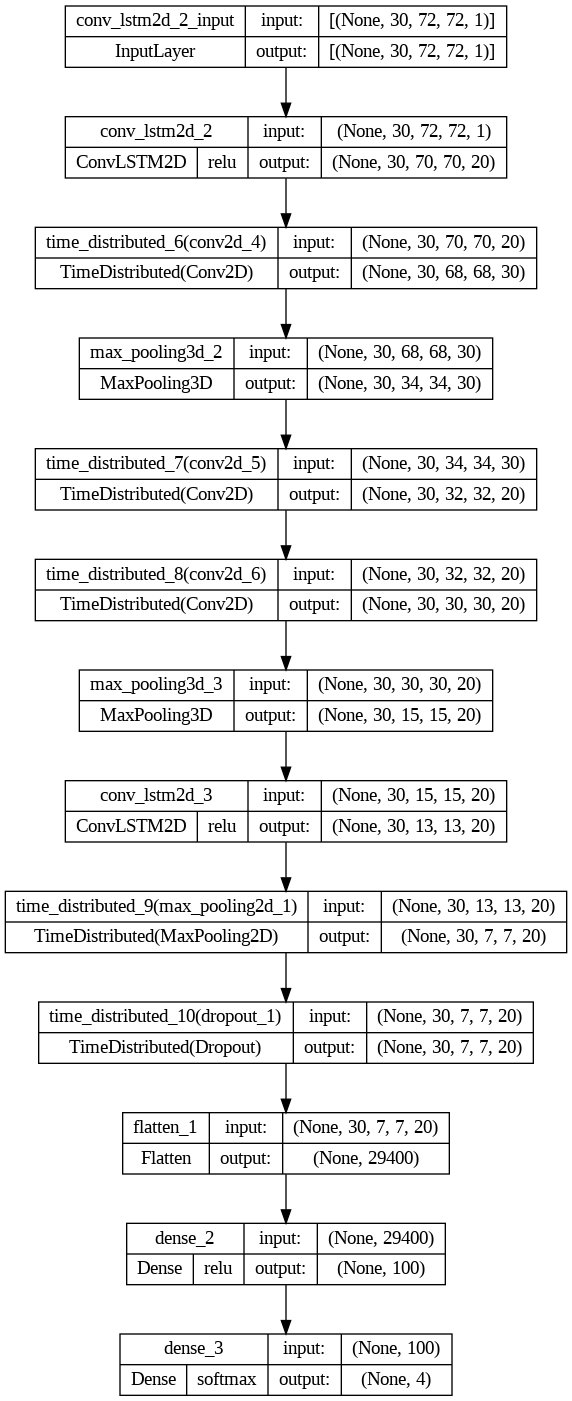

In [ ]:
#ploting Model
plot_model(model,
           show_shapes=True,
           to_file='model.png',
           show_layer_names=True,
           show_layer_activations=True)

In [ ]:
#data agumentation
from keras.models import Sequential
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomZoom
import numpy as np

# train_data i shape (samples, time, height, width, channels)

train_data = x_train_shaped
augmented_data = []

# Define a Sequential model to apply augmentation to each frame
augmentation_model = Sequential()
# augmentation_model.add(RandomFlip(mode='horizontal'))  # Randomly flip horizontally
augmentation_model.add(RandomRotation(factor=0.1, fill_mode='reflect', interpolation='bilinear'))  # Random rotation within 20%
augmentation_model.add(RandomZoom(height_factor=0.2, width_factor=0.2, fill_mode='reflect', interpolation='bilinear'))  # Random zoom within 20%

# Loop through each sample and apply augmentation to each frame
for sample in train_data:
    augmented_sample = [augmentation_model(np.expand_dims(frame, axis=0), training=True).numpy()[0] for frame in sample]
    augmented_data.append(augmented_sample)

# Convert the augmented data back to a numpy array
augmented_data = np.array(augmented_data)
augmented_data.shape


(602, 30, 72, 72, 1)

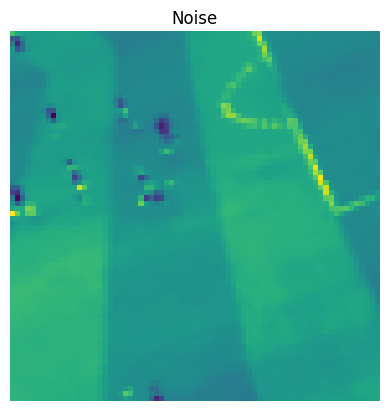

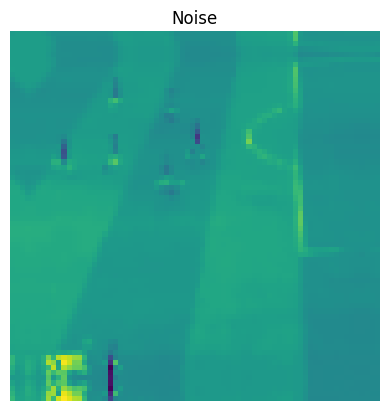

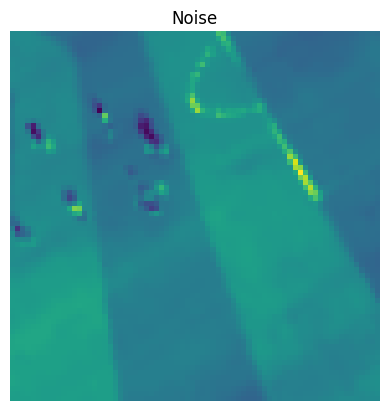

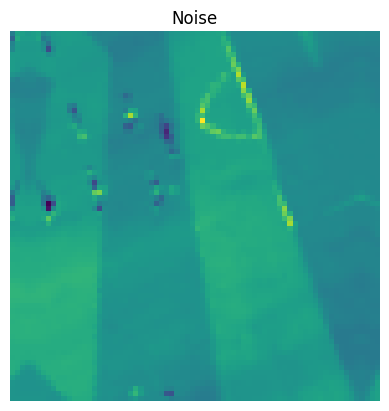

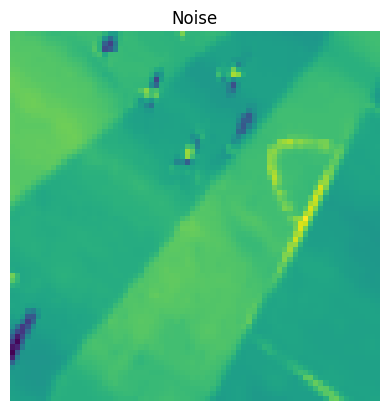

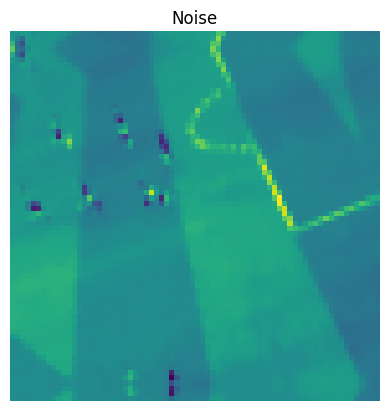

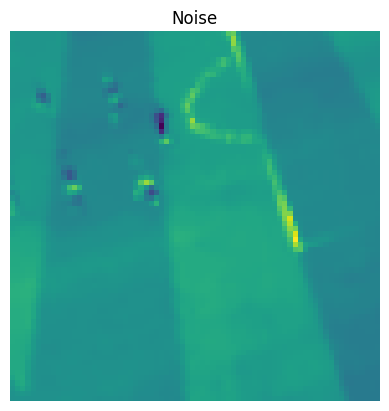

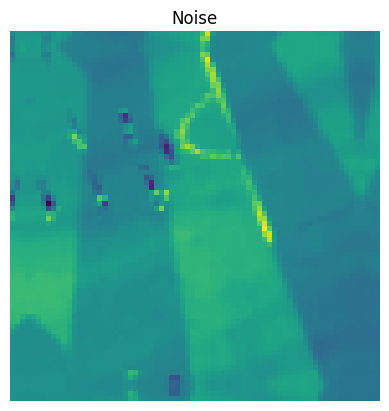

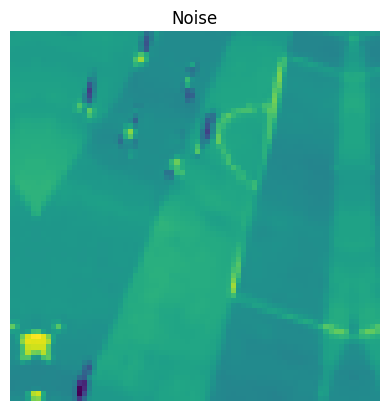

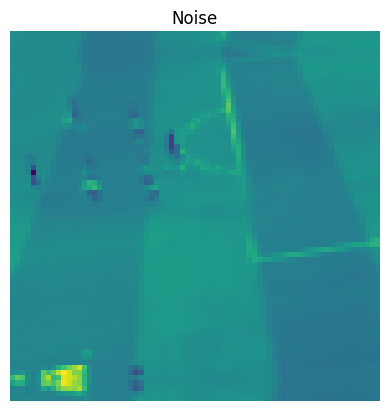

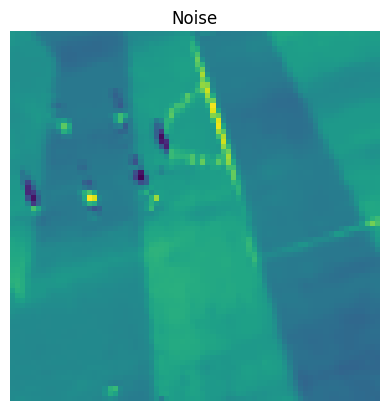

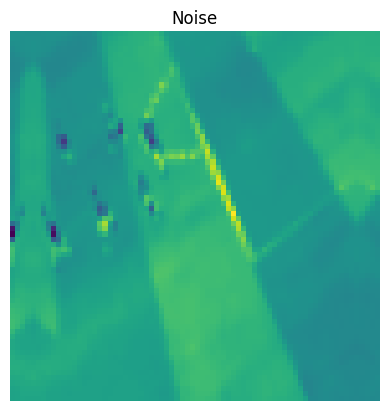

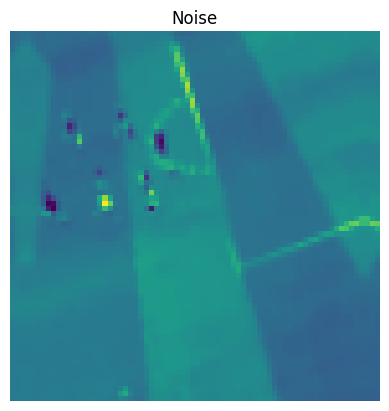

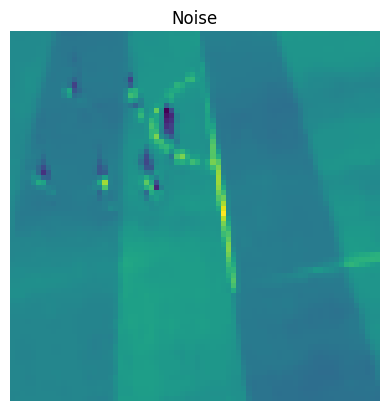

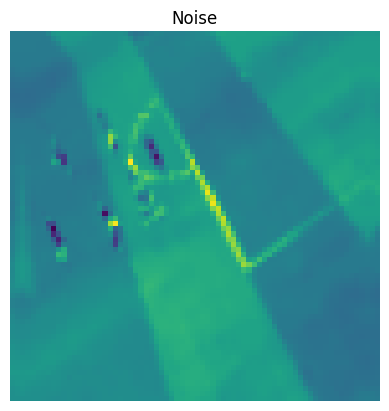

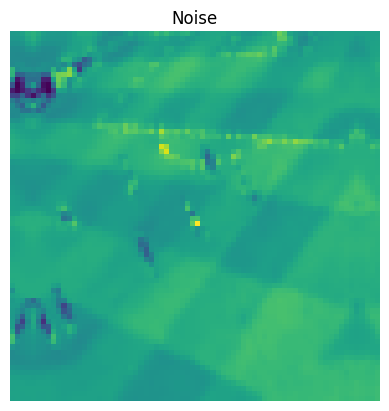

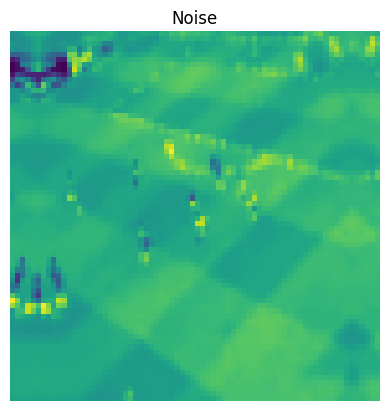

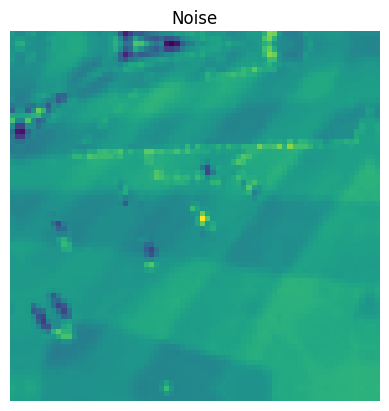

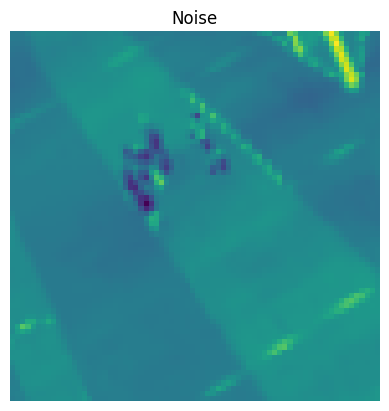

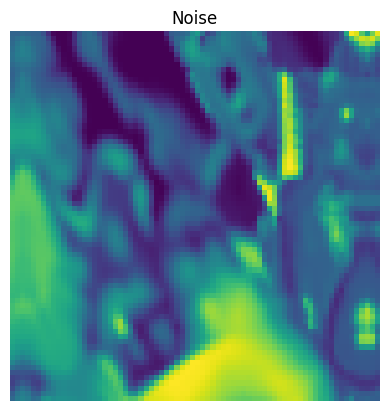

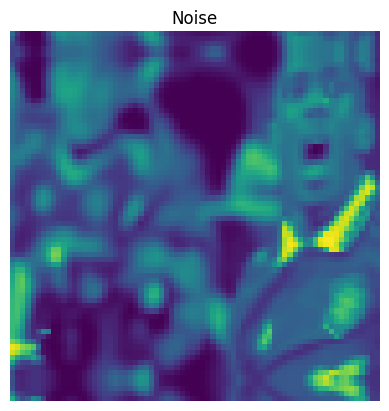

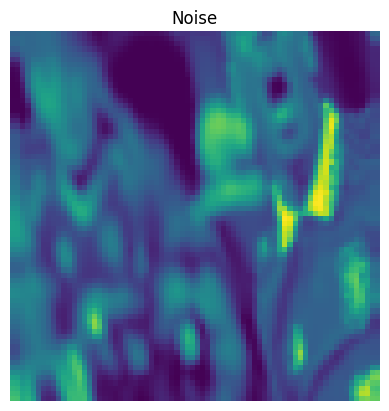

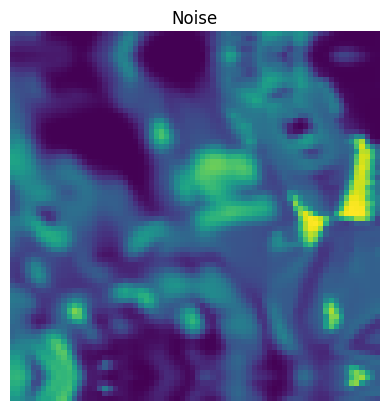

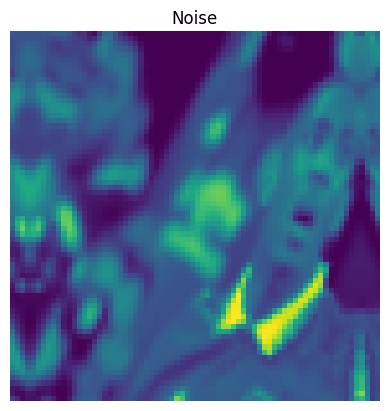

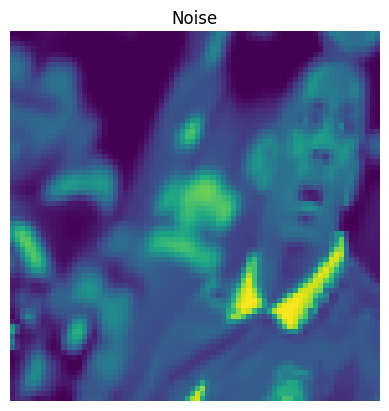

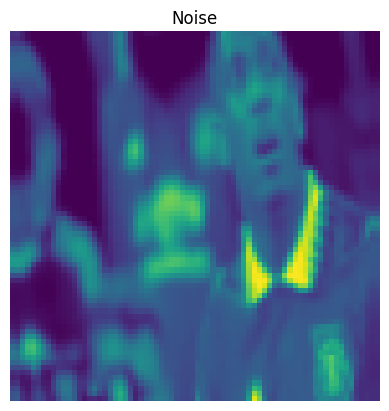

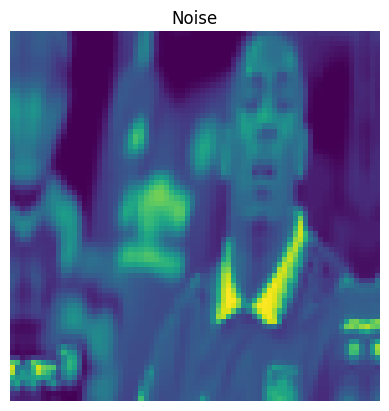

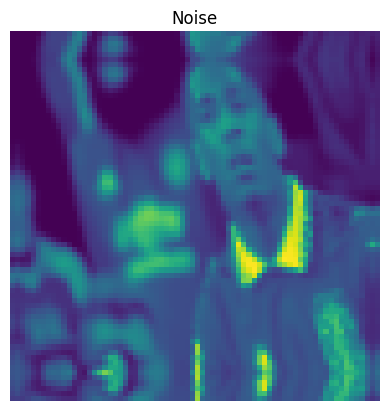

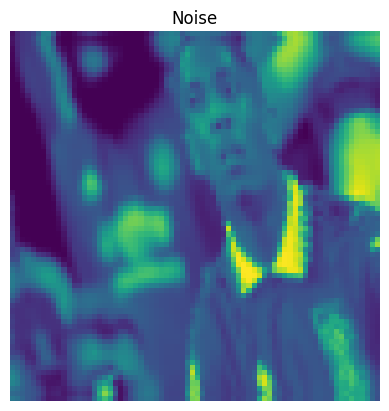

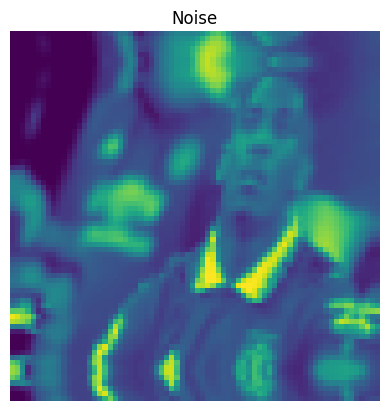

In [ ]:
key = 400
for index in range(30):
  plt.title(class_names[y_train[key]])
  plt.imshow(augmented_data[key][index])
  plt.axis('off')
  plt.show()

In [ ]:
#Model compilation
from keras.optimizers import Adam
from keras import backend as K
adam = Adam(learning_rate=0.0005)#0.001
model.compile(loss='sparse_categorical_crossentropy',metrics='accuracy',optimizer=adam)

In [ ]:
#Training Model
#time of training 45min
print("Longer than you think")
history = model.fit(augmented_data,y_train,
                   validation_split = 0.2,
                   epochs=50,
                   callbacks=EarlyStopping(monitor='val_loss',patience=10,restore_best_weights=True))

Longer than you think
Epoch 1/50
16/16 [==============================] - 25s 1s/step - loss: 1.3762 - accuracy: 0.2848 - val_loss: 1.3409 - val_accuracy: 0.2975
Epoch 2/50
16/16 [==============================] - 18s 1s/step - loss: 1.3203 - accuracy: 0.4262 - val_loss: 1.2489 - val_accuracy: 0.2975
Epoch 3/50
16/16 [==============================] - 18s 1s/step - loss: 1.0708 - accuracy: 0.4761 - val_loss: 1.1449 - val_accuracy: 0.5537
Epoch 4/50
16/16 [==============================] - 18s 1s/step - loss: 0.9390 - accuracy: 0.5489 - val_loss: 1.0600 - val_accuracy: 0.5620
Epoch 5/50
16/16 [==============================] - 17s 1s/step - loss: 0.8372 - accuracy: 0.6299 - val_loss: 0.9031 - val_accuracy: 0.6198
Epoch 6/50
16/16 [==============================] - 19s 1s/step - loss: 0.8117 - accuracy: 0.6881 - val_loss: 0.8978 - val_accuracy: 0.5868
Epoch 7/50
16/16 [==============================] - 17s 1s/step - loss: 0.7580 - accuracy: 0.6611 - val_loss: 0.8451 - val_accuracy: 0.694

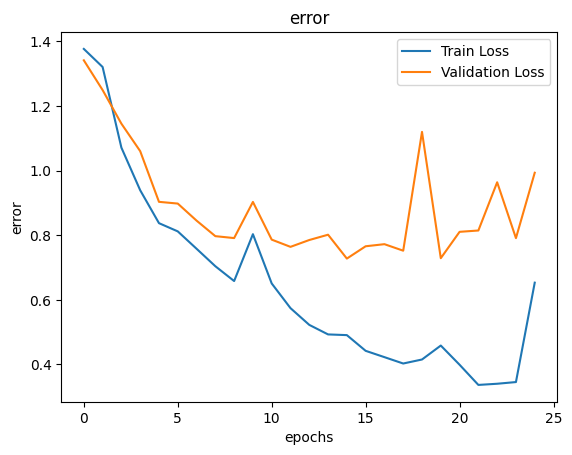

In [ ]:
#plotting histories
plt.plot(history.history['loss'],label='Train Loss')
plt.plot(history.history['val_loss'],label='Validation Loss')
plt.title("error")
plt.xlabel('epochs')
plt.ylabel('error')
plt.legend()

In [ ]:
#predicting
pred = model.predict(x_test)

9/9 [==============================] - 2s 208ms/step


In [ ]:
pred = [np.argmax(i) for i in pred]

In [ ]:
#Libraries for measuring accuracy
from sklearn import metrics
import seaborn as sns

print(metrics.accuracy_score(y_test,pred)*100,"% accuracy")

71.31782945736434 % accuracy


In [ ]:
#classificaiton report
print(metrics.classification_report(pred,y_test,target_names=class_names))

              precision    recall  f1-score   support

        Gool       0.49      1.00      0.66        34
    FreeKick       0.55      0.65      0.59        51
        Foul       1.00      0.64      0.78        72
       Noise       0.86      0.70      0.77       101

    accuracy                           0.71       258
   macro avg       0.72      0.75      0.70       258
weighted avg       0.79      0.71      0.72       258



In [ ]:
#confusion Matrix
cm = metrics.confusion_matrix(pred,y_test)

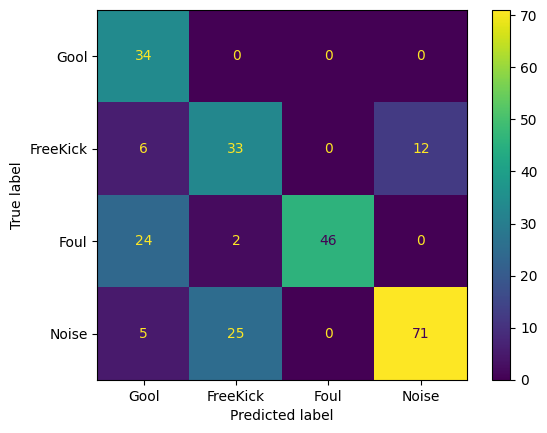

In [ ]:
#ploting matrix
display = metrics.ConfusionMatrixDisplay(cm,display_labels=class_names)
display.plot()


# Detecting scene from 1min video


In [ ]:
def get_scene(path,n_sequence,image_height,image_width):
  skip_sequence = 3
  reader = cv2.VideoCapture(path)
  success , frame = reader.read()
  count = 0
  total_sequence = 0
  scene_list = []
  scene = []
  frame_count = int(reader.get(cv2.CAP_PROP_FRAME_COUNT))
  print("totoal frame is ",frame_count)
  n = int(frame_count/60)
  while(success):
    #changing color to GRAY
    #frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
    frame = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
    frame = cv2.resize(frame,(image_height,image_width))
    if(count==n_sequence):
      scene_list.append(scene)
      count = 0
      scene = []
    scene.append(frame)
    count +=1
    total_sequence +=1
    # reader.set(cv2.CAP_PROP_POS_FRAMES,total_sequence*skip_sequence)
    #skipping sequence
    # for _ in range(skip_sequence-1):
    #   success,frame = reader.read()
    success,frame = reader.read()
    # print(len(scene_list))
  print("total sequence is ",total_sequence)
  x = np.array(scene_list)
  reader.release
  return x



In [ ]:
#dividing video to scenes
input_video = '/content/1min_video1.avi'
x_1 = get_scene(input_video,N_SEQUENCE,image_height=IMG_HEIGHT,image_width=IMG_WIDTH)

totoal frame is  1800
total sequence is  1799


In [ ]:
#result from video scene
print(x_1.shape)


(59, 30, 72, 72)


In [ ]:
#Normilization result
x_scenes = x_1/255

In [ ]:
#prediction from scene
out_put = model.predict(x_scenes)

2/2 [==============================] - 1s 206ms/step


In [ ]:
#converting posibility to class_index
out_put_index = [np.argmax(i) for i in out_put]
result_scenes_class = [class_names[i] for i in out_put_index]


In [ ]:
unique_class,_ = np.unique(result_scenes_class,return_counts=True)
unique_class = unique_class.tolist()
unique_class.remove('Noise')
class_thresh = 10
occurance = {}
i=0
for u in range(len(unique_class)):
   while i < len(result_scenes_class):
        if unique_class[u] == result_scenes_class[i]:
            if unique_class[u] in occurance:
                occurance[unique_class[u]] += 1
            else:
                occurance[unique_class[u]] = 1
            i += class_thresh  # Jump i by class_thresh steps
        else:
            i += 1  # Move to the next element
   i=0
print(occurance)

{'FreeKick': 4}


In [ ]:
#summary
ss = []
ss.append('The match video clip includes ')
for key,value in occurance.items():
  ss.append(f'{value} {key}, ')
print(ss)
text = ' '.join(ss)

['The match video clip includes ', '4 FreeKick, ']


In [ ]:
!pip install sumy
import nltk
nltk.download('punkt')
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.lex_rank import LexRankSummarizer

parser = PlaintextParser.from_string(text, Tokenizer("english"))
summarizer = LexRankSummarizer()
summary = summarizer(parser.document, 2)
for sentence in summary:
    print(sentence)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


The match video clip includes  1 Foul,  5 FreeKick,


In [ ]:
from nltk.tokenize import sent_tokenize
from heapq import nlargest

sentences = sent_tokenize(text)
sentence_scores = {sentence: len(sentence) for sentence in sentences}
summary_sentences = nlargest(2, sentence_scores, key=sentence_scores.get)
for sentence in summary_sentences:
    print(sentence)

The match video clip includes  1 Foul,  5 FreeKick,


# Model 2

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, LSTM, MaxPooling3D, MaxPooling2D, TimeDistributed, Flatten, Dense, Dropout,ConvLSTM2D,Reshape
from keras import layers
def build_model(n_sequence=N_SEQUENCE,IMAGE_HEIGHT=72,IMAGE_WIDTH=72,num_classes=len(class_names)):
  num_filters_conv1 = 30
  num_filters_conv2 = 40
  num_filters_conv3 = 40
  num_units_dense1 = 100

  model = Sequential()

  model.add(layers.ConvLSTM2D(
        filters=10,
        kernel_size=(3,3),
        recurrent_dropout = 0.2,
        activation="relu",
        return_sequences=True,
        data_format="channels_last",
        #change chanel to 1 for GRAY Scale
        input_shape=(n_sequence,IMAGE_HEIGHT,IMAGE_WIDTH,1)
    ))
  model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same', data_format='channels_last')))
  model.add(TimeDistributed(Conv2D(
      filters=num_filters_conv1,
      kernel_size=(3, 3),
      activation="relu",
      data_format="channels_last"),input_shape=(n_sequence,IMAGE_HEIGHT,IMAGE_WIDTH,1)))
  model.add(ConvLSTM2D(
    filters=20,
    kernel_size=(3, 3),
    activation='relu',
    padding='same',
    return_sequences=True
  ))
  model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same', data_format='channels_last')))

  model.add(ConvLSTM2D(
    filters=20,
    kernel_size=(3, 3),
    activation='relu',
    padding='same',
    return_sequences=True
  ))

  model.add(TimeDistributed(MaxPooling2D(pool_size=( 2, 2), padding='same', data_format="channels_last")))
  model.add(ConvLSTM2D(
    filters=30,
    kernel_size=(3, 3),
    activation='relu',
    padding='same',
    return_sequences=True
  ))
  model.add(TimeDistributed(Conv2D(
      filters=num_filters_conv3,
      kernel_size=(3, 3),
      activation="relu",
      data_format="channels_last")
  ))

  model.add(TimeDistributed(MaxPooling2D(pool_size=( 2, 2), padding='same', data_format="channels_last")))
  # model.add(TimeDistributed(Conv2D(
  #     filters=num_filters_conv3,
  #     kernel_size=(3, 3),
  #     activation="relu",
  #     data_format="channels_last")
  # ))
  model.add(TimeDistributed(Dropout(0.1)))
  model.add(Flatten())
  # model.add(LSTM(num_units_dense1, activation='relu', return_sequences=False))
  model.add(Dense(100,activation='relu'))
  model.add(Dense(num_classes, activation='softmax'))
  return model


In [ ]:
#creating model
model2 = build_model(n_sequence=N_SEQUENCE,IMAGE_HEIGHT=IMG_HEIGHT,IMAGE_WIDTH=IMG_WIDTH)
model2.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_20 (ConvLSTM2D  (None, 30, 70, 70, 10)    4000      
 )                                                               
                                                                 
 time_distributed_36 (TimeD  (None, 30, 35, 35, 10)    0         
 istributed)                                                     
                                                                 
 time_distributed_37 (TimeD  (None, 30, 33, 33, 30)    2730      
 istributed)                                                     
                                                                 
 conv_lstm2d_21 (ConvLSTM2D  (None, 30, 33, 33, 20)    36080     
 )                                                               
                                                                 
 time_distributed_38 (TimeD  (None, 30, 17, 17, 20)   

In [ ]:
#Model compilation
from keras.optimizers import Adam
from keras import backend as K
adam = Adam(learning_rate=0.0005)#0.001
model2.compile(loss='sparse_categorical_crossentropy',metrics='accuracy',optimizer=adam)

In [ ]:
history = model2.fit(augmented_data,y_train,
                   validation_split = 0.2,
                   epochs=50,
                   callbacks=EarlyStopping(monitor='val_loss',patience=10,restore_best_weights=True))

Epoch 1/50
16/16 [==============================] - 34s 1s/step - loss: 1.3858 - accuracy: 0.2765 - val_loss: 1.3717 - val_accuracy: 0.2975
Epoch 2/50
16/16 [==============================] - 19s 1s/step - loss: 1.3773 - accuracy: 0.2973 - val_loss: 1.3553 - val_accuracy: 0.2975
Epoch 3/50
16/16 [==============================] - 19s 1s/step - loss: 1.3222 - accuracy: 0.2973 - val_loss: 1.3212 - val_accuracy: 0.2975
Epoch 4/50
16/16 [==============================] - 22s 1s/step - loss: 1.2735 - accuracy: 0.3451 - val_loss: 1.3169 - val_accuracy: 0.4711
Epoch 5/50
16/16 [==============================] - 19s 1s/step - loss: 1.2349 - accuracy: 0.3950 - val_loss: 1.1778 - val_accuracy: 0.5950
Epoch 6/50
16/16 [==============================] - 19s 1s/step - loss: 1.0535 - accuracy: 0.4969 - val_loss: 1.1099 - val_accuracy: 0.5372
Epoch 7/50
16/16 [==============================] - 19s 1s/step - loss: 0.9959 - accuracy: 0.6133 - val_loss: 0.9969 - val_accuracy: 0.6364
Epoch 8/50
16/16 [==

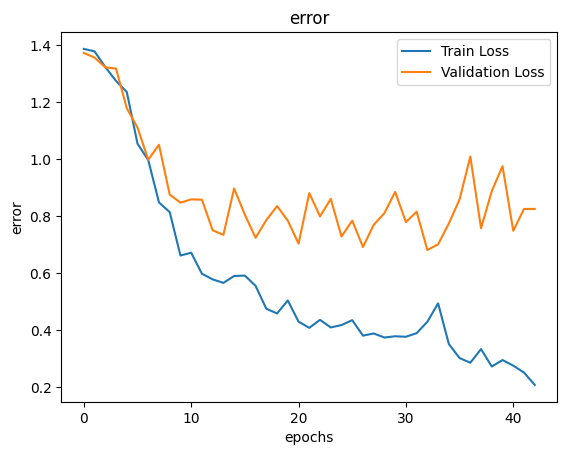

In [ ]:
#plotting histories
plt.plot(history.history['loss'],label='Train Loss')
plt.plot(history.history['val_loss'],label='Validation Loss')
plt.title("error")
plt.xlabel('epochs')
plt.ylabel('error')
plt.legend()

In [ ]:
pred2 = model2.predict(x_test)
pred2 = [np.argmax(i) for i in pred2]

9/9 [==============================] - 4s 231ms/step


In [ ]:
#Libraries for measuring accuracy
from sklearn import metrics
import seaborn as sns

print(metrics.accuracy_score(y_test,pred2)*100,"% accuracy")

81.0077519379845 % accuracy


In [ ]:
# @title Default title text
print(metrics.classification_report(pred2,y_test,target_names=class_names))

              precision    recall  f1-score   support

        Gool       0.86      0.95      0.90        62
    FreeKick       0.60      0.71      0.65        51
        Foul       0.93      0.90      0.91        48
       Noise       0.86      0.73      0.79        97

    accuracy                           0.81       258
   macro avg       0.81      0.82      0.81       258
weighted avg       0.82      0.81      0.81       258



In [ ]:
cm = metrics.confusion_matrix(pred2,y_test)

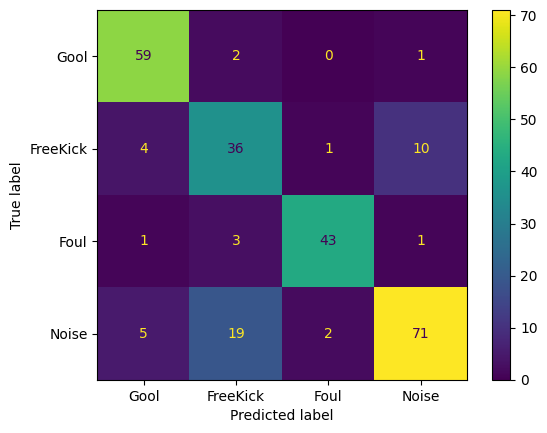

In [ ]:
#ploting matrix
display = metrics.ConfusionMatrixDisplay(cm,display_labels=class_names)
display.plot()

# 1min video

In [ ]:
out_put2 = model2.predict(x_scenes)
out_put_index = [np.argmax(i) for i in out_put2]
result_scenes_class2 = [class_names[i] for i in out_put_index]

2/2 [==============================] - 0s 183ms/step


In [ ]:
unique_class,_ = np.unique(result_scenes_class2,return_counts=True)
unique_class = unique_class.tolist()
unique_class.remove('Noise')
class_thresh = 10
occurance = {}
i=0
for u in range(len(unique_class)):
   while i < len(result_scenes_class2):
        if unique_class[u] == result_scenes_class2[i]:
            if unique_class[u] in occurance:
                occurance[unique_class[u]] += 1
            else:
                occurance[unique_class[u]] = 1
            i += class_thresh  # Jump i by class_thresh steps
        else:
            i += 1  # Move to the next element
   i=0
print(occurance)

{'Foul': 1, 'FreeKick': 4, 'Gool': 1}


In [ ]:
ss = []
ss.append('The match video clip includes ')
for key,value in occurance.items():
  ss.append(f'{value} {key}, ')
print(ss)
text = ' '.join(ss)


['The match video clip includes ', '1 Foul, ', '4 FreeKick, ', '1 Gool, ']
